# Artificial Neural Networks

### Import libraries

In [1]:
# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Activation, Dropout
# from keras.layers.normalization import BatchNormalization
# from keras import metrics
# from keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np
from scipy import ndimage, fft
import matplotlib.pyplot as plt
import math
import time

from imblearn.over_sampling import SMOTE

from pathlib import Path

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.metrics import classification_report

# from .preprocess_data import LightFluxProcessor
import tensorflow as tf

2025-01-14 10:04:33.070484: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 10:04:33.321605: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-14 10:04:33.555246: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736845473.741906    1989 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736845473.786177    1989 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 10:04:34.466313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Functions used to preprocess both the *data_no_injection* and the *data_injected* datasets are reported below: 

In [2]:
class LightFluxProcessor:

    def __init__(self, fourier=True, normalize=True, gaussian=True, standardize=True):
        self.fourier = fourier
        self.normalize = normalize
        self.gaussian = gaussian
        self.standardize = standardize

    # Computing the FFT on X and returning the amplitude of the frequencies in the signal 
    def fourier_transform(self, X):
        return np.abs(fft.fft(X, n=X.size))

    # Applying fourier transform
    def process(self, df_train_x, df_dev_x):
        if self.fourier:
            print("Applying Fourier...")
            shape_train = df_train_x.shape
            shape_dev = df_dev_x.shape
            df_train_x = df_train_x.apply(self.fourier_transform, axis=1)
            df_dev_x = df_dev_x.apply(self.fourier_transform, axis=1)

            # builds new arrays to sore the transformed rows 
            df_train_x_build = np.zeros(shape_train)
            df_dev_x_build = np.zeros(shape_dev)

            for ii, x in enumerate(df_train_x): #?
                df_train_x_build[ii] = x

            for ii, x in enumerate(df_dev_x): #?
                df_dev_x_build[ii] = x

            df_train_x = pd.DataFrame(df_train_x_build)
            df_dev_x = pd.DataFrame(df_dev_x_build)

            # Keep first half of data as it is symmetrical after previous steps (FFT results are symmetric)
            df_train_x = df_train_x.iloc[:, : (df_train_x.shape[1] // 2)].values
            df_dev_x = df_dev_x.iloc[:, : (df_dev_x.shape[1] // 2)].values

        # Normalizing to unit norm
        if self.normalize:
            print("Normalizing...")
            df_train_x = pd.DataFrame(normalize(df_train_x)) 
            df_dev_x = pd.DataFrame(normalize(df_dev_x))

            # df_train_x = df_train_x.div(df_train_x.sum(axis=1), axis=0)
            # df_dev_x = df_dev_x.div(df_dev_x.sum(axis=1), axis=0)

        # Gaussian filter to smooth out data (to remove noise)
        if self.gaussian:
            print("Applying Gaussian Filter...")
            df_train_x = ndimage.gaussian_filter(df_train_x, sigma=10)
            df_dev_x = ndimage.gaussian_filter(df_dev_x, sigma=10)

        # Standardize X data
        if self.standardize:
            print("Standardizing...")
            std_scaler = StandardScaler()
            df_train_x = std_scaler.fit_transform(df_train_x)
            df_dev_x = std_scaler.transform(df_dev_x)

        print("Finished Processing!")
        return df_train_x, df_dev_x

In [3]:
def load_data(train_dataset_path, dev_dataset_path):
    print("Loading datasets...")
    df_train = pd.read_csv(train_dataset_path, encoding="ISO-8859-1")
    df_dev = pd.read_csv(dev_dataset_path, encoding="ISO-8859-1")

    # Generate X and Y dataframe sets
    df_train_x = df_train.drop("LABEL", axis=1)
    df_dev_x = df_dev.drop("LABEL", axis=1)
    df_train_y = df_train.LABEL
    df_dev_y = df_dev.LABEL

    # Process dataset with LPF
    LFP = LightFluxProcessor(
        fourier=True, normalize=True, gaussian=True, standardize=True
    )
    df_train_x, df_dev_x = LFP.process(df_train_x, df_dev_x)

    # Rejoin X and Y to form dataframe 
    df_train_processed = pd.DataFrame(df_train_x).join(pd.DataFrame(df_train_y))
    df_dev_processed = pd.DataFrame(df_dev_x).join(pd.DataFrame(df_dev_y))

    # Load X and Y numpy arrays
    X_train, Y_train = np_X_Y_from_df(df_train_processed)
    X_dev, Y_dev = np_X_Y_from_df(df_dev_processed)

    # Print data set stats
    (num_examples, n_x) = (X_train.shape)  # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[1]  # n_y : output size
    print("X_train.shape: ", X_train.shape)
    print("Y_train.shape: ", Y_train.shape)
    print("X_dev.shape: ", X_dev.shape)
    print("Y_dev.shape: ", Y_dev.shape)
    
    return X_train, Y_train, X_dev, Y_dev

### Build the model 

We begin by defining the neural network architecture. The model includes a configurable number of fully connected (dense) hidden layers, each paired with a ReLU activation function to introduce non-linearity. To enhance generalization and reduce overfitting, dropout regularization is applied after each dense layer. Finally, a single dense layer with a sigmoid activation function serves as the output layer.

In [4]:
np.random.seed(1)

def build_network(shape, n_layers, n_neurons):

    model = tf.keras.models.Sequential(
        [
        tf.keras.layers.Input(shape), # input layer defined by 'shape' parameter  
        tf.keras.layers.Flatten(), # covert into 1d array
        ])
    
    for n in range(n_layers):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))  # Dense layer with 1 unit and ReLU
        model.add(tf.keras.layers.Dropout(rate=0.25)) # Dropout layer to prevent overfitting 
    
    model.add(tf.keras.layers.Dense(1, activation="sigmoid")) # output layer with sigmoid

    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False) # False as we applied a sigmoid activation function so we interpret the outputs as probabilities 
    model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
    return model

# output: X (numpy array of features) and Y (numpy array of lables - 1 or 2)
def np_X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(["LABEL"], axis=1)
    X = np.array(df_X)
    Y_raw = np.array(df["LABEL"]).reshape((len(df["LABEL"]), 1))
    Y = Y_raw == 2
    return X, Y


## Assignment 2F

The aim of this task is to identify planets in the *data_no_injection* dataset. 

In [9]:
path_to_data = '/home/gaia/third_semester/COMP-ASTRO/data/machine_learning/kepler'
train_dataset_path = f"{path_to_data}/data_no_injection/exoTrain.csv"
dev_dataset_path = f"{path_to_data}/data_no_injection/exoTest.csv"

LOAD_MODEL = True  # continue training previous weights or start fresh
RENDER_PLOT = True  # render loss and accuracy plots

Below we run the model with deafult parameters (one hidden layer and one neuron per layer):

Loading datasets...
Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!
X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)


2025-01-14 10:06:29.219072: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Training...


/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gaia/third_semester/COMP-ASTRO/compastro/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


train set error 0.007273442107332384
dev set error 0.00877192982456143
------------
precision_train 0.0
precision_dev 0.0
------------
recall_train 0.0
recall_dev 0.0
------------
confusion_matrix_train
[[5050    0]
 [  37    0]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
Train Set Positive Predictions 0
Dev Set Positive Predictions 0
------------
All 0's error train set 0.007273442107332416
All 0's error dev set 0.008771929824561403
------------
------------
dict_keys(['accuracy', 'loss'])


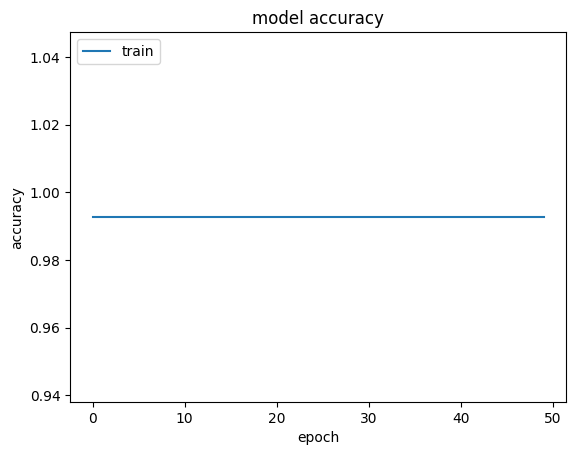

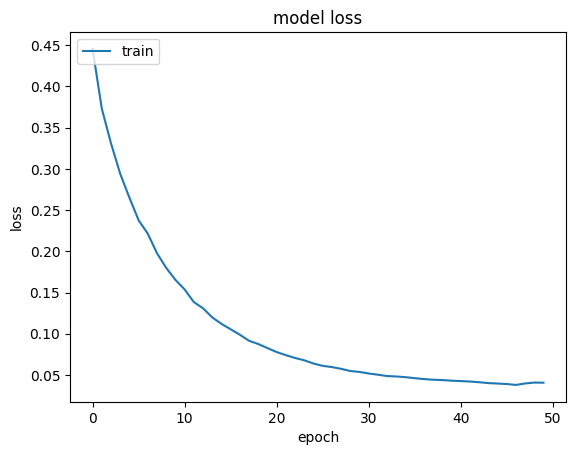

In [10]:
X_train, Y_train, X_dev, Y_dev = load_data(train_dataset_path, dev_dataset_path)
model = build_network(X_train.shape[1:], n_layers=1, n_neurons=1)

# Training the NN 
print("Training...")

history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)

train_outputs = model.predict(X_train, batch_size=32, verbose=0) 
dev_outputs = model.predict(X_dev, batch_size=32, verbose=0) 
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)

# Metrics
accuracy_train = accuracy_score(Y_train, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

print("train set error", 1.0 - accuracy_train)
print("dev set error", 1.0 - accuracy_dev)
print("------------")
print("precision_train", precision_train)
print("precision_dev", precision_dev)
print("------------")
print("recall_train", recall_train)
print("recall_dev", recall_dev)
print("------------")
print("confusion_matrix_train")
print(confusion_matrix_train)
print("confusion_matrix_dev")
print(confusion_matrix_dev)
print("------------")
print("Train Set Positive Predictions", np.count_nonzero(train_outputs))
print("Dev Set Positive Predictions", np.count_nonzero(dev_outputs))
#  Predicting 0's will give you error:
print("------------")
print("All 0's error train set", 37 / 5087)
print("All 0's error dev set", 5 / 570)

print("------------")
print("------------")

if RENDER_PLOT:
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history["accuracy"])
    # plt.plot(history.history['val_acc'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

    # summarize history for loss
    plt.plot(history.history["loss"])
    # plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

We go on varying the number of layers and number of neurons per layer, analyzing the confusion matrices to determine the best performing architecture.

In [11]:
import itertools

n_layers = [1,2,3]
n_neurons = [16,32,64]
combinations = list(itertools.product(n_layers, n_neurons))

for combo in combinations:
    model = build_network(X_train.shape[1:], n_layers=combo[0], n_neurons=combo[1])

    # Training the NN 
    print(f"Training with {combo[0]} hidden layers and {combo[1]} neurons per layer...")

    history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)

    train_outputs = model.predict(X_train, batch_size=32, verbose=0) 
    dev_outputs = model.predict(X_dev, batch_size=32, verbose=0) 
    train_outputs = np.rint(train_outputs)
    dev_outputs = np.rint(dev_outputs)

    confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

    print("confusion_matrix_train")
    print(confusion_matrix_train)
    print("confusion_matrix_dev")
    print(confusion_matrix_dev)

    print("------------")
    print("------------")

Training with 1 hidden layers and 16 neurons per layer...
confusion_matrix_train
[[5048    2]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 1 hidden layers and 32 neurons per layer...
confusion_matrix_train
[[5048    2]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 1 hidden layers and 64 neurons per layer...
confusion_matrix_train
[[5050    0]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 2 hidden layers and 16 neurons per layer...
confusion_matrix_train
[[5050    0]
 [  37    0]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 2 hidden layers and 32 neurons per layer...
confusion_matrix_train
[[5043    7]
 [   0   37]]
confusion_matrix_dev
[[565   0]
 [  5   0]]
------------
------------
Training with 2 hidden layers and 64 neurons per layer...
confusion_matrix_train
[[5050    0]
 [  37    0]]
co

Just like we have already observed in Assignment 2C, the highly unbalanced nature of the dataset makes it hard to detect systems with exoplanets. All the implemented feedforward neural network architectures have similar behavior on the development set.

## Assignment 2F

We proceed by working on the *data_injected* dataset.

Loading datasets...


Applying Fourier...
Normalizing...
Applying Gaussian Filter...
Standardizing...
Finished Processing!
X_train.shape:  (5087, 1598)
Y_train.shape:  (5087, 1)
X_dev.shape:  (570, 1598)
Y_dev.shape:  (570, 1)
Training...
train set error 0.43483389030862984
dev set error 0.44561403508771935
------------
precision_train 0.5640165713158414
precision_dev 0.5543859649122806
------------
recall_train 0.9993009437259699
recall_dev 1.0
------------
confusion_matrix_train
[[  16 2210]
 [   2 2859]]
confusion_matrix_dev
[[  0 254]
 [  0 316]]
------------
Train Set Positive Predictions 5069
Dev Set Positive Predictions 570
------------
All 0's error train set 0.007273442107332416
All 0's error dev set 0.008771929824561403
------------
------------
dict_keys(['accuracy', 'loss'])


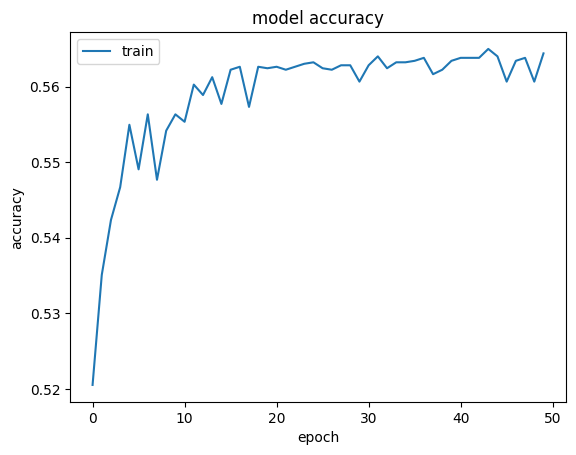

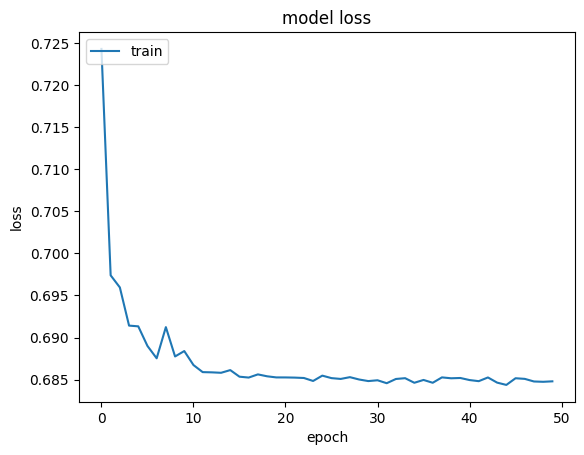

In [12]:
train_dataset_path = f"{path_to_data}/data_injected/exoTrain.csv"
dev_dataset_path = f"{path_to_data}/data_injected/exoTest.csv"

X_train, Y_train, X_dev, Y_dev = load_data(train_dataset_path, dev_dataset_path)
model = build_network(X_train.shape[1:], n_layers=1, n_neurons=1)

# Training the NN 
print("Training...")

history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)

train_outputs = model.predict(X_train, batch_size=32, verbose=0) 
dev_outputs = model.predict(X_dev, batch_size=3, verbose=0) 
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)

# Metrics
accuracy_train = accuracy_score(Y_train, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

print("train set error", 1.0 - accuracy_train)
print("dev set error", 1.0 - accuracy_dev)
print("------------")
print("precision_train", precision_train)
print("precision_dev", precision_dev)
print("------------")
print("recall_train", recall_train)
print("recall_dev", recall_dev)
print("------------")
print("confusion_matrix_train")
print(confusion_matrix_train)
print("confusion_matrix_dev")
print(confusion_matrix_dev)
print("------------")
print("Train Set Positive Predictions", np.count_nonzero(train_outputs))
print("Dev Set Positive Predictions", np.count_nonzero(dev_outputs))
#  Predicting 0's will give you error:
print("------------")
print("All 0's error train set", 37 / 5087)
print("All 0's error dev set", 5 / 570)

print("------------")
print("------------")

if RENDER_PLOT:
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history["accuracy"])
    # plt.plot(history.history['val_acc'])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

    # summarize history for loss
    plt.plot(history.history["loss"])
    # plt.plot(history.history['val_loss'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "test"], loc="upper left")
    plt.show()

Just like in the previous case, we implement different architectures:

In [13]:
for combo in combinations:
    model = build_network(X_train.shape[1:], n_layers=combo[0], n_neurons=combo[1])


    # Training the NN 
    print(f"Training with {combo[0]} hidden layers and {combo[1]} neurons per layer...")

    history = model.fit(X_train, Y_train, epochs=50, batch_size=32, verbose=0)

    train_outputs = model.predict(X_train, batch_size=32, verbose=0) 
    dev_outputs = model.predict(X_dev, batch_size=32, verbose=0) 
    train_outputs = np.rint(train_outputs)
    dev_outputs = np.rint(dev_outputs)

    
    accuracy_train = accuracy_score(Y_train, train_outputs)
    accuracy_dev = accuracy_score(Y_dev, dev_outputs)
    confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
    confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

    print("train set error", 1.0 - accuracy_train)
    print("dev set error", 1.0 - accuracy_dev)
    print("------------")
    print("confusion_matrix_train")
    print(confusion_matrix_train)
    print("confusion_matrix_dev")
    print(confusion_matrix_dev)

    print("------------")
    print("------------")

Training with 1 hidden layers and 16 neurons per layer...
train set error 0.43326125417731476
dev set error 0.4473684210526315
------------
confusion_matrix_train
[[  89 2137]
 [  67 2794]]
confusion_matrix_dev
[[ 51 203]
 [ 52 264]]
------------
------------
Training with 1 hidden layers and 32 neurons per layer...
train set error 0.4314920385295852
dev set error 0.44561403508771935
------------
confusion_matrix_train
[[  56 2170]
 [  25 2836]]
confusion_matrix_dev
[[  0 254]
 [  0 316]]
------------
------------
Training with 1 hidden layers and 64 neurons per layer...


train set error 0.43070572046392763
dev set error 0.4368421052631579
------------
confusion_matrix_train
[[ 193 2033]
 [ 158 2703]]
confusion_matrix_dev
[[ 28 226]
 [ 23 293]]
------------
------------
Training with 2 hidden layers and 16 neurons per layer...
train set error 0.43503046982504423
dev set error 0.44561403508771935
------------
confusion_matrix_train
[[  15 2211]
 [   2 2859]]
confusion_matrix_dev
[[  0 254]
 [  0 316]]
------------
------------
Training with 2 hidden layers and 32 neurons per layer...
train set error 0.428346766266955
dev set error 0.44561403508771935
------------
confusion_matrix_train
[[  79 2147]
 [  32 2829]]
confusion_matrix_dev
[[  0 254]
 [  0 316]]
------------
------------
Training with 2 hidden layers and 64 neurons per layer...
train set error 0.4181246314134067
dev set error 0.4473684210526315
------------
confusion_matrix_train
[[ 186 2040]
 [  87 2774]]
confusion_matrix_dev
[[  1 253]
 [  2 314]]
------------
------------
Training with 3 hid

It is easy to observe how Support Vector Machines and Neural Networks provide a similar result on this particular dataset: they are unable to accurately classify neither of the two classes. This is due to the fact that the signal-to-noise ratio is too low, systems with simulated exoplanets are too close to the background noise.